# Word2vec + Logic Regression

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import os
import datetime
import sys
import numpy as np

sys.path.append('../')
from TrainSettings import TrainSettings
from tqdm import tqdm
import swifter

import torch
import torch.nn as nn
import torch.optim as optim

import json

In [2]:
settings = TrainSettings()
datasets_path = "../../datasets/"

tqdm.pandas()

## Подготовка данных

In [3]:
train_file = datasets_path + settings.settings['all']['DATASET_NAME'] + "/" + settings.settings['all']['LANG'] + "/prep/" + 'train' + "_" + settings.settings['all']['LANG'] + ".csv"
test_file = datasets_path + settings.settings['all']['DATASET_NAME'] + "/" + settings.settings['all']['LANG'] + "/prep/" + 'test' + "_" + settings.settings['all']['LANG'] + ".csv"

df_train = pd.read_csv(train_file, sep='\t', on_bad_lines='warn')
df_test = pd.read_csv(test_file, sep='\t', on_bad_lines='warn')

### Объеденяем поля с текстом

In [4]:
df_train['text'] = (df_train['title'] if settings.settings['all']['DATASET_USE_TITLE'] else '') \
                 + df_train['body'] \
                 + (df_train['keywords'] if settings.settings['all']['DATASET_USE_KEYWORDS'] else '')

df_test['text'] = (df_test['title'] + ' ' if settings.settings['all']['DATASET_USE_TITLE'] else '') \
                + df_test['body'] \
                + (' ' + df_test['keywords'] if settings.settings['all']['DATASET_USE_KEYWORDS'] else '')

### Удаляем невалидные данные

In [5]:
df_train = df_train[df_train['correct'] == '###']

df_test = df_test[df_test['correct'] == '###']

### Удаляем лишние столбцы

In [6]:
df_train = df_train.drop("title", axis=1)
df_train = df_train.drop("body", axis=1)
df_train = df_train.drop("keywords", axis=1)
df_train = df_train.drop("correct", axis=1)

df_test = df_test.drop("title", axis=1)
df_test = df_test.drop("body", axis=1)
df_test = df_test.drop("keywords", axis=1)
df_test = df_test.drop("correct", axis=1)

df_train['RGNTI'] = df_train[settings.settings['all']['LEVEL']].str.split('\\', n=1, expand=True)[0]
df_test['RGNTI'] = df_test[settings.settings['all']['LEVEL']].str.split('\\', n=1, expand=True)[0]

df_train = df_train.drop("RGNTI1", axis=1)
df_train = df_train.drop("RGNTI2", axis=1)
df_train = df_train.drop("RGNTI3", axis=1)
df_train = df_train.dropna().drop_duplicates()

df_test = df_test.drop("RGNTI1", axis=1)
df_test = df_test.drop("RGNTI2", axis=1)
df_test = df_test.drop("RGNTI3", axis=1)
df_test = df_test.dropna().drop_duplicates()

### Статистика

RGNTI
00       50
06     7817
12      196
15     2318
19      358
20     2672
27     5931
28     4174
29    34415
30     6562
31    26132
34    43257
36     2185
37     4114
38    10195
39     4657
41     5639
44    11323
45     4403
47     8058
49     3702
50     5213
52     7695
53    10104
55    16009
58        4
59        5
60     1251
61    18935
62      379
64     1203
65     2477
66      493
67      357
68     3091
69      144
70     3312
73     9182
75      306
76     4033
81     5597
82     2189
86       27
87     6463
89     1727
90     1897
dtype: int64


<Axes: xlabel='RGNTI'>

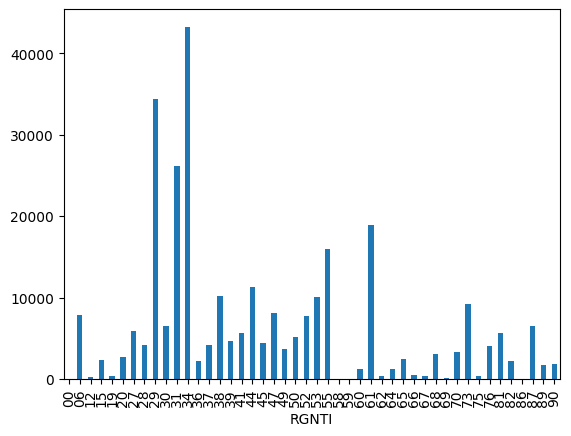

In [7]:
print(df_train.groupby('RGNTI').size())
 
# Plotting the bar chart
%matplotlib inline
df_train.groupby('RGNTI').size().plot(kind='bar')

### Удаляем лишиние тексты, чтобы избежать переобучения

In [8]:
a = df_train.groupby('RGNTI').size().to_dict()
print(a)
t = []
for i in a:
  if a[i] > 15000:
    t.append(i)
print(t)

{'00': 50, '06': 7817, '12': 196, '15': 2318, '19': 358, '20': 2672, '27': 5931, '28': 4174, '29': 34415, '30': 6562, '31': 26132, '34': 43257, '36': 2185, '37': 4114, '38': 10195, '39': 4657, '41': 5639, '44': 11323, '45': 4403, '47': 8058, '49': 3702, '50': 5213, '52': 7695, '53': 10104, '55': 16009, '58': 4, '59': 5, '60': 1251, '61': 18935, '62': 379, '64': 1203, '65': 2477, '66': 493, '67': 357, '68': 3091, '69': 144, '70': 3312, '73': 9182, '75': 306, '76': 4033, '81': 5597, '82': 2189, '86': 27, '87': 6463, '89': 1727, '90': 1897}
['29', '31', '34', '55', '61']


In [9]:
for i in t:
  print(df_train.shape)
  ids = df_train.index[df_train['RGNTI'] == i].tolist()
  ids = ids[15000:]
  df_train = df_train.drop(ids)
  print(df_train.shape)

(290251, 3)
(270836, 3)
(270836, 3)
(259704, 3)
(259704, 3)
(231447, 3)
(231447, 3)
(230438, 3)
(230438, 3)
(226503, 3)


### Убираем тексты, в которых меньше текстов, чем задано в настройках

In [10]:
df_train = df_train.groupby('RGNTI').filter(lambda x: len(x) > settings.settings['all']['MIN_TEXTS']['RGNTI1'])

### Проведем токенезацию, лемматизацию и удалим стоп слова

In [11]:
df_train['text'] = df_train['text'].astype(str).swifter.progress_bar(enable=True, desc='bar description').apply(lambda x: x.split())

bar description: 100%|██████████| 174779/174779 [00:01<00:00, 149621.38it/s]


In [12]:
df_train.head()

,id,text,RGNTI
0,19.06-73.269,"[некоторый, аспект, изменение, степной, ландша...",87
1,19.01-24А.85,"[подход, повышение, точность, определение, хар...",47
2,19.06-66.105,"[микроскопический, моделирование, фазовый, пол...",53
3,19.06-14Б.10,"[модель, и, методика, автоматизация, процедура...",55
4,19.10-19Ж.456,"[трехкомпонентный, реакция, кастагноли-кушмана...",31


### Подготовим конвертацию класса в число и обратно.

In [13]:
compYtoRGNTI_ = set(df_train['RGNTI'].to_list())
compYtoRGNTI = {}
n = 0
for i in compYtoRGNTI_:
  compYtoRGNTI[n] = i
  n += 1

compRGNTItoY = dict((v,k) for k,v in compYtoRGNTI.items())

## Word2Vec

### Векторизация

In [13]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    min_count=10,
    window=2,
    vector_size=300,
    negative=10,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=1,
    workers=16)

In [14]:
w2v_model.build_vocab(df_train['text'])

In [15]:
try:
  w2v_model = Word2Vec.load('test.model')
except IOError as e:
  print(u'не удалось открыть файл')
  w2v_model.train(df_train['text'].to_list(), total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
  w2v_model.save('test.model')

не удалось открыть файл


In [16]:
def vectorize(words):
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train = np.array([vectorize(sentence) for sentence in tqdm(df_train['text'])])

100%|██████████| 168928/168928 [00:12<00:00, 13370.65it/s]


In [17]:
compYtoRGNTI_ = set(df_train['RGNTI'].to_list())
compYtoRGNTI = {}
n = 0
for i in compYtoRGNTI_:
  compYtoRGNTI[n] = i
  n += 1

compRGNTItoY = dict((v,k) for k,v in compYtoRGNTI.items())
df_test = df_test[df_test['RGNTI'].isin(compYtoRGNTI_)]

X_test = np.array([vectorize(sentence) for sentence in tqdm(df_test['text'])])
y_train = df_train['RGNTI'].apply(lambda x: compRGNTItoY[x])
y_test = df_test['RGNTI'].apply(lambda x: compRGNTItoY[x])

100%|██████████| 122024/122024 [01:09<00:00, 1750.77it/s]


### LogisticRegression

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
report = classification_report(y_train, y_pred, output_dict=True)
with open("LR", "w") as outfile:
  s = json.dumps(report, indent=2, sort_keys=False)
  outfile.write(s)

In [19]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.01      0.01      3363
           1       0.00      0.00      0.00      3223
           2       0.00      0.00      0.00      4525
           3       0.00      0.00      0.00      5601
           4       0.20      1.00      0.34     24612
           5       0.00      0.00      0.00      2981
           6       0.00      0.00      0.00      8985
           7       0.00      0.00      0.00      9777
           8       0.00      0.00      0.00      4400
           9       0.00      0.00      0.00     14814
          10       0.00      0.00      0.00      6502
          11       0.00      0.00      0.00      4252
          12       0.00      0.00      0.00      3532
          13       0.00      0.00      0.00     10741
          14       0.00      0.00      0.00      5820
          15       0.00      0.00      0.00      3725
          16       0.00      0.00      0.00      5171

    accuracy              

## make_classification

In [20]:
from sklearn.datasets import make_classification

RGNTI
06     7815
27     5930
29    15000
30     6563
31    15000
34    15000
38    10192
44    11292
47     8044
50     5177
52     7647
53    10082
55    15000
61    15000
73     9136
81     5593
87     6457
dtype: int64


<Axes: xlabel='RGNTI'>

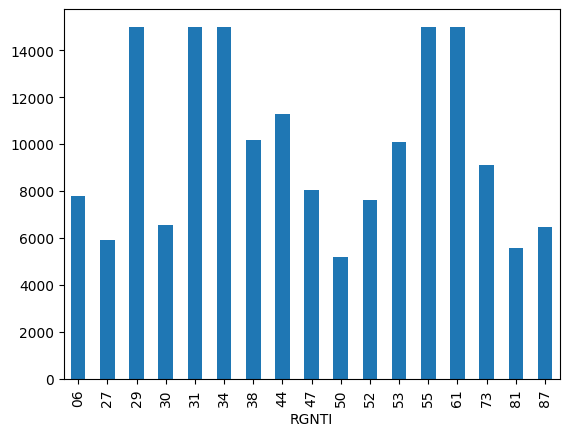

In [21]:
print(df_train.groupby('RGNTI').size())
 
# Plotting the bar chart
%matplotlib inline
df_train.groupby('RGNTI').size().plot(kind='bar')

In [34]:
w2v_model.wv["нитро"]

array([-0.3562949 , -0.35792848,  0.13880935,  0.79563594,  0.99232435,
        0.0448926 ,  0.01920044,  0.7500043 , -0.61313814,  0.11589482,
       -0.05742182,  0.19985412,  0.05389038,  0.25011584, -0.16964814,
       -0.21106064,  0.39442548, -0.59551316, -0.4343899 ,  0.20625256,
       -0.9382189 , -0.82432055, -0.00989888, -0.23810421,  0.95218146,
        0.8681721 , -0.02898183, -0.2644287 , -0.4448449 , -0.6834768 ,
        0.40666142, -0.15208934, -0.46611878,  0.11680568,  0.2921717 ,
       -0.03274706,  0.3853908 , -0.75870204,  0.02614522, -0.10673977,
       -0.18806624, -0.25950885,  0.21803173, -0.27091077,  0.05465139,
       -0.09172762, -0.36046147,  0.3676333 ,  0.01768082,  0.23939651,
       -0.22204673, -0.26993912, -0.14429098,  0.44650477,  0.7198802 ,
        0.10967705,  0.01734681, -0.05369901, -0.11511034, -0.24470901,
        0.15967582, -0.09406238, -0.20866245, -0.3059815 , -0.00327304,
        0.14416584,  0.06395297, -0.59018755, -0.42451182, -0.25

In [14]:
import sys
sys.path.append('../')
from TrainSettings import TrainSettings
from VectorizeWord2Vec import VectorizeWord2Vec


In [15]:
sett = TrainSettings('test/')
a = VectorizeWord2Vec(sett.settings['word2vec'], 'test/')

In [16]:
a.build_vocab(df_train['text'])

In [17]:
a.train(df_train['text'])

In [18]:
b = a.vectorizeAll(df_train['text'])

100%|██████████| 174779/174779 [00:15<00:00, 11355.27it/s]


In [19]:
print(b)

[[ 0.1198934   0.15063566 -0.06735732 ...  0.22716272 -0.01946696
   0.237634  ]
 [ 0.22418377  0.05161492 -0.07512373 ...  0.25202987  0.06953149
   0.21904346]
 [ 0.18090962  0.01606935 -0.08545087 ...  0.21947992  0.0216587
   0.2057931 ]
 ...
 [ 0.25288987  0.08418306 -0.10722949 ...  0.34370646  0.03911312
   0.22883682]
 [ 0.13488577  0.12061148 -0.21230961 ...  0.28470534  0.00131655
   0.25394276]
 [ 0.25106606  0.10882937 -0.1195773  ...  0.34808996  0.06359631
   0.26807913]]
